### 座標とポテンシャルエネルギーを訓練データとして、エネルギー関数のパラメータkを学習する

### 必要なパッケージを読み込む

In [83]:
using Flux, Plots
using ChainRulesCore
using Statistics
using Random
#using Distributions
using MDToolbox

In [2]:
epoch_n = 1
pdb_filepath = "./alanine-dipeptide-nowater.pdb"
ff_input_txt_dir = "./outdir/epoch_$(epoch_n)/forcefield"
ff_output_txt_filepath = joinpath(ff_input_txt_dir, "epoch_$(epoch_n)_estimated.xml")
traj_dir = "./outdir/epoch_$(epoch_n)/dihedral"
njobs = 5

5

### ポテンシャルエネルギー関数の定義

In [3]:
#二面角のポテンシャルの計算
function compute_dihedral_energy(theta, theta_zero, n, k)
    U = k * (1 + cos(n * theta - theta_zero))
    return U
end

compute_dihedral_energy (generic function with 1 method)

In [4]:
function ChainRulesCore.rrule(::typeof(compute_dihedral_energy), theta, theta_zero, n, k)
    U = k * (1 + cos(n * theta - theta_zero))
    
    function compute_dihedral_energy_pullback(dU)
        dtheta = -k * n * sin(n * theta - theta_zero) * dU
        dtheta_zero = k * sin(n * theta - theta_zero) * dU
        dn = -k * theta * sin(n * theta - theta_zero) * dU
        dk = 1 + cos(n * theta - theta_zero) * dU
        return NoTangent(), dtheta, dtheta_zero, dn, dk
    end
    return U, compute_dihedral_energy_pullback
end

In [5]:
#nステップ目のポテンシャルを計算
function sum_compute_dihedral_energy(theta, theta_zero_array, n_array, k_array)
    #U = 0
    #for i in 1:size(n_array, 1)
    #    U += compute_dihedral_energy(theta, theta_zero_array[i], n_array[i], k_array[i])
    #end
    U = reduce(+, [compute_dihedral_energy(theta, theta_zero_array[i], n_array[i], k_array[i]) for i in 1:size(n_array, 1)])
    return U
end

sum_compute_dihedral_energy (generic function with 1 method)

In [53]:
#二面角からFを計算
function compute_free_energy(phi_array, psi_array, beta,
        theta_zero_phi_array, n_phi_array, k_phi_array, theta_zero_psi_array, n_psi_array, k_psi_array)
    N = size(phi_array, 1)
    U = 0 
    #for i in 1:N
    #    U += (sum_compute_dihedral_energy(phi_array, theta_zero_phi_array, n_phi_array, k_phi_array) 
    #        + sum_compute_dihedral_energy(psi_array, theta_zero_psi_array, n_psi_array, k_psi_array))
    #end
    #for文で書くと勾配計算でエラーが起こるためリスト内包表記を用いる
    U_array = [(sum_compute_dihedral_energy(phi_array[i], theta_zero_phi_array, n_phi_array, k_phi_array) 
            + sum_compute_dihedral_energy(psi_array[i], theta_zero_psi_array, n_psi_array, k_psi_array)) for i in 1:N]
    F = (-1 / beta) * (log(1 / N) + MDToolbox.logsumexp_1d(-beta .* U_array))
    return F
end

compute_free_energy (generic function with 1 method)

In [48]:
# exponential averaging
function compute_deltaF(phi_array, psi_array, beta,
        theta_zero_phi_array, n_phi_array, k_phi_array, theta_zero_psi_array, n_psi_array, k_psi_array, U_array) #パラメータは全てターゲットのもの,U_arrayはターゲットでないポテンシャルの配列
    N = size(phi, 1)
    U_target_array = [sum_compute_dihedral_energy(phi_array[i], theta_zero_phi_array, n_phi_array, k_phi_array) + sum_compute_dihedral_energy(psi_array[i], theta_zero_psi_array, n_psi_array, k_psi_array) for i in 1:N]
    deltaU = U_target_array .- U_array
    #@show deltaU
    #deltaF = (-1 / beta) * log((1 / N) * sum(exp.(-beta .* deltaU)))
    deltaF = (-1 / beta) * (log(1 / N) + MDToolbox.logsumexp_1d(-beta .* deltaU))
    return deltaF
end

compute_deltaF (generic function with 1 method)

## ffパラメータ

In [8]:
# txtファイルから力場パラメータを取り出す関数
function output_ff_parameter(ff_input_txt_filepath)
    f = open(ff_input_txt_filepath, "r")
    datalist = readlines(f)
    close
        
    #output
    theta_zero_phi = []
    k_phi = []
    n_phi = []
    theta_zero_psi = []
    k_psi = []
    n_psi = []
    
    current = "PHI"   
    #create phi parameter
    for line in datalist
        if(line == "PHI_PARAMETER")
            continue
        #"PSI_PARAMETER"が現れたらcurrent->"PSI"
        elseif(line == "PSI_PARAMETER")
            current = "PSI"
            continue
        end        
        #parameterを配列に格納していく
        #phi
        if(current == "PHI")
            if(occursin(r"type.*", split(line)[1]))
                continue
            elseif(occursin(r"periodicity.*", split(line)[1]))
                push!(n_phi, parse(Float64, split(line)[2]))
            elseif(occursin(r"phase.*", split(line)[1]))
                push!(theta_zero_phi, parse(Float64, split(line)[2]))
            elseif(occursin(r"k.*", split(line)[1]))
                push!(k_phi, parse(Float64, split(line)[2]))
            else
                println("ERROR")
            end
        end 
        #psi
        if(current == "PSI")
            if(occursin(r"type.*", split(line)[1]))
                continue
            elseif(occursin(r"periodicity.*", split(line)[1]))
                push!(n_psi, parse(Float64, split(line)[2]))
            elseif(occursin(r"phase.*", split(line)[1]))
                push!(theta_zero_psi, parse(Float64, split(line)[2]))
            elseif(occursin(r"k.*", split(line)[1]))
                push!(k_psi, parse(Float64, split(line)[2]))
            else
                println("ERROR")
            end
        end
    end
    return theta_zero_phi, k_phi, n_phi, theta_zero_psi, k_psi, n_psi
end

output_ff_parameter (generic function with 1 method)

In [9]:
theta_zero_phi_k = []
k_phi_k = []
n_phi_k = []
theta_zero_psi_k = []
k_psi_k = []
n_psi_k = []

for i in 1:njobs
    ff_input_txt_filepath = joinpath(ff_input_txt_dir, "epoch_$(epoch_n)_$(i).txt")
    theta_zero_phi, k_phi, n_phi, theta_zero_psi, k_psi, n_psi = output_ff_parameter(ff_input_txt_filepath)
    push!(theta_zero_phi_k, theta_zero_phi)
    push!(k_phi_k, k_phi)
    push!(n_phi_k, n_phi)
    push!(theta_zero_psi_k, theta_zero_psi)
    push!(k_psi_k, k_psi)
    push!(n_psi_k, n_psi)
end

### input dihedral traj

In [10]:
#for i in 1:njobs
#    dcd_filepath = joinpath(traj_dir, "traj$(i).dcd")
#    output_filepath = joinpath(traj_dir, "traj$(i).txt")
#    run(`python ./create_dihedral_traj.py $(pdb_filepath) $(dcd_filepath) $(output_filepath)`)
#end

In [11]:
data_k = [] #data[i][1] = phi[i], data[i][2] = psi[i]
for i in 1:njobs
    path = joinpath(traj_dir, "traj$(i).txt")
    #file input
    f = open(path, "r")
    list = readlines(f)
    close

    data = []
    for j in 1:size(split.(list), 1)
        tmp =  split(list[j])
        phi = parse(Float64, tmp[1])
        psi = parse(Float64, tmp[2])
        push!(data, (phi, psi))
    end
    push!(data_k, data)
end

## input target

In [74]:
# forcefield
ff_input_txt_filepath = "./target.txt"
theta_zero_phi_target, k_phi_target, n_phi_target, theta_zero_psi_target, k_psi_target, n_psi_target = output_ff_parameter(ff_input_txt_filepath)
# traj
path = "./traj_target.txt"
#file input
f = open(path, "r")
list = readlines(f)
close

data_target = []
for j in 1:size(split.(list), 1)
    tmp =  split(list[j])
    phi = parse(Float64, tmp[1])
    psi = parse(Float64, tmp[2])
    push!(data_target, (phi, psi))
end

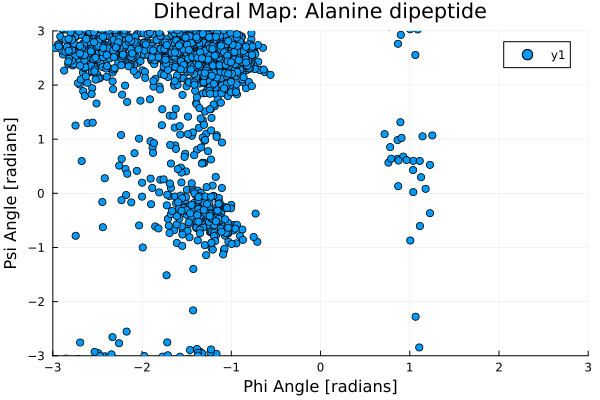

In [13]:
#plot
k = 5
phi = map(x -> x[1], data_k[k])
psi = map(x -> x[2], data_k[k])
plot(phi[1:50:end], psi[1:50:end], st=scatter,
    xlabel="Phi Angle [radians]", ylabel="Psi Angle [radians]", title=("Dihedral Map: Alanine dipeptide"),
    xlim=(-3,3),ylim=(-3,3))

## エネルギー計算確かめ

In [70]:
#エネルギー計算、確かめ用 MBAR
data_k_copy = deepcopy(data_k)
push!(data_k_copy, data_target)
k_phi_k_copy = deepcopy(k_phi_k)
push!(k_phi_k_copy, k_phi_target)
k_psi_k_copy = deepcopy(k_psi_k)
push!(k_psi_k_copy, k_psi_target)

K = size(data_k_copy, 1)
kBT = 0.1
beta = 1.0/(kBT)
u_kl = Array{Any}(undef, (K, K))

for k = 1:K
    for l = 1:K
        #u_kl[k, l] = map(x -> beta * compute_energy(x[1], x[2], epsilon[l], sigma[l]),data_k[k])
        u_kl[k, l] = (map(x -> beta * sum_compute_dihedral_energy(x[1], theta_zero_phi_k[1], n_phi_k[1], k_phi_k_copy[l]), data_k_copy[k])
                    + map(x -> beta * sum_compute_dihedral_energy(x[2], theta_zero_psi_k[1], n_psi_k[1], k_psi_k_copy[l]), data_k_copy[k]))
    end
end

f_k = mbar(u_kl)
@show deltaF_k = (1 / beta) .* f_k

iteration = 1  delta = 2.264531e+00  tol = 1.000000e-08
free energies =  0.000000 -0.001556 -0.404859 0.450164 -0.275516 2.042945

iteration = 2  delta = 1.812478e-01  tol = 1.000000e-08
free energies =  0.000000 0.002411 -0.402685 0.458948 -0.294957 2.219220

iteration = 3  delta = 2.674782e-02  tol = 1.000000e-08
free energies =  0.000000 0.003991 -0.400379 0.459154 -0.298199 2.245507

iteration = 4  delta = 4.140020e-03  tol = 1.000000e-08
free energies =  0.000000 0.004264 -0.399974 0.459161 -0.298713 2.249582

iteration = 5  delta = 6.451230e-04  tol = 1.000000e-08
free energies =  0.000000 0.004308 -0.399910 0.459162 -0.298793 2.250217

iteration = 6  delta = 1.006302e-04  tol = 1.000000e-08
free energies =  0.000000 0.004314 -0.399900 0.459162 -0.298806 2.250316

iteration = 7  delta = 1.569938e-05  tol = 1.000000e-08
free energies =  0.000000 0.004315 -0.399898 0.459162 -0.298808 2.250331

iteration = 8  delta = 2.449332e-06  tol = 1.000000e-08
free energies =  0.000000 0.00431

6-element Vector{Float64}:
  0.0
  0.0004315657296616646
 -0.039989783046337574
  0.04591618877316861
 -0.029880805658175632
  0.2250334234323352

In [75]:
#EXP
U_array_k = []
for i in 1:njobs
    U_array = (map(x -> sum_compute_dihedral_energy(x[1], theta_zero_phi_k[1], n_phi_k[1], k_phi_k_copy[i]), data_k_copy[i])
            +map(x -> sum_compute_dihedral_energy(x[2], theta_zero_psi_k[1], n_psi_k[1], k_psi_k_copy[i]), data_k_copy[i]))
    push!(U_array_k, U_array)
end

In [76]:
phi = map(x -> x[1], data_k[1])
psi = map(x -> x[2], data_k[1])
for i in 1:6
    deltaF = compute_deltaF(phi, psi, beta,
            theta_zero_phi_k[1], n_phi_k[1], k_phi_k_copy[i], theta_zero_psi_k[1], n_psi_k[1], k_psi_k_copy[i], U_array_k[1])
    println("deltaF = $(deltaF)")
end

deltaF = -0.0
deltaF = -0.0013813292290137725
deltaF = -0.04274029405872142
deltaF = 0.04538316930656716
deltaF = -0.027535856008181092
deltaF = 0.20390251809985235


## エネルギー計算

In [73]:
#数値積分
K = njobs
kBT = 0.1
beta = 1.0/(kBT)
#compute F1
phi = map(x -> x[1], data_k[1])
psi = map(x -> x[2], data_k[1])
F1 = compute_free_energy(phi, psi, beta, theta_zero_phi_k[1], n_phi_k[1], k_phi_k[1], theta_zero_psi_k[1], n_psi_k[1], k_psi_k[1])

for k in 1:K
    phi = map(x -> x[1], data_k[k])
    psi = map(x -> x[2], data_k[k])
    
    F = compute_free_energy(phi, psi, beta, theta_zero_phi_k[k], n_phi_k[k], k_phi_k[k], theta_zero_psi_k[k], n_psi_k[k], k_psi_k[k])
    deltaF = F - F1
    println("deltaF$(k) = $(deltaF)")
end
data_target
#target
phi = map(x -> x[1], data_target)
psi = map(x -> x[2], data_target)

F = compute_free_energy(phi, psi, beta, theta_zero_phi_k[1], n_phi_k[1], k_phi_target, theta_zero_psi_k[1], n_psi_k[1], k_psi_target)
deltaF = F - F1
println("deltaF_target = $(deltaF)")

deltaF1 = 0.0
deltaF2 = -0.014912293274776722
deltaF3 = -0.029953007799264686
deltaF4 = -0.037513007522763875
deltaF5 = 0.003984106667045184
deltaF_target = 0.01470077653036661


In [77]:
kBT = 0.1
beta = 1.0/(kBT)
K = njobs
u_kl = Array{Any}(undef, (K, K))

for k = 1:K
    for l = 1:K
        #u_kl[k, l] = map(x -> beta * compute_energy(x[1], x[2], epsilon[l], sigma[l]),data_k[k])
        u_kl[k, l] = (map(x -> beta * sum_compute_dihedral_energy(x[1], theta_zero_phi_k[l], n_phi_k[l], k_phi_k[l]), data_k[k])
                    + map(x -> beta * sum_compute_dihedral_energy(x[2], theta_zero_psi_k[l], n_psi_k[l], k_psi_k[l]), data_k[k]))
    end
end

In [78]:
f_k = mbar(u_kl)
@show (1 / beta) .* f_k

iteration = 1  delta = 1.369819e+00  tol = 1.000000e-08
free energies =  0.000000 -0.001919 -0.404226 0.448544 -0.273882

iteration = 2  delta = 2.452998e-02  tol = 1.000000e-08
free energies =  0.000000 -0.005325 -0.412355 0.453858 -0.272773

iteration = 3  delta = 6.596536e-04  tol = 1.000000e-08
free energies =  0.000000 -0.005442 -0.412574 0.453979 -0.272679

iteration = 4  delta = 1.929864e-05  tol = 1.000000e-08
free energies =  0.000000 -0.005445 -0.412580 0.453982 -0.272675

iteration = 5  delta = 5.735523e-07  tol = 1.000000e-08
free energies =  0.000000 -0.005445 -0.412580 0.453982 -0.272675

iteration = 6  delta = 1.709684e-08  tol = 1.000000e-08
free energies =  0.000000 -0.005445 -0.412580 0.453982 -0.272675

iteration = 7  delta = 5.099340e-10  tol = 1.000000e-08
free energies =  0.000000 -0.005445 -0.412580 0.453982 -0.272675

iteration = 8  delta = 1.520879e-11  tol = 1.000000e-08
free energies =  0.000000 -0.005445 -0.412580 0.453982 -0.272675

iteration = 9  delta = 4

5-element Vector{Float64}:
  0.0
 -0.0005445306620256102
 -0.04125801240918889
  0.04539824916889526
 -0.027267538656340996

## To do
- mbar_fを用いてエネルギー計算を行う
- EXP、数値積分、MBARと比べてどの程度差が出ているかを確認する
- 勾配計算により、どの程度改善できたかを確かめる

In [79]:
#mbar_f
u_k = Vector{Any}(undef, K)

for k = 1:K
    u_k[k] = (map(x -> beta * sum_compute_dihedral_energy(x[1], theta_zero_phi_target, n_phi_target, k_phi_target), data_k[1])
                + map(x -> beta * sum_compute_dihedral_energy(x[2], theta_zero_psi_target, n_psi_target, k_psi_target), data_k[1]))
end

f_target = MDToolbox.mbar_f(u_kl, f_k, u_k)
@show f_target
(1 ./ beta) * (f_target - f_k[1])

LoadError: UndefVarError: `mbar_f` not defined

In [86]:
MDToolbox.mbar_f

LoadError: UndefVarError: `mbar_f` not defined

### ΔFを求める

In [ ]:
kBT = 0.1
beta = 1.0/(kBT)
nstep = size(phi, 1)

#FとF_targetを計算
@show F = compute_free_energy(phi, psi, beta, theta_zero, n, k)
@show F_target = compute_free_energy(phi_target, psi_target, beta, theta_zero_target, n_target, k_target)

@show y_train = F_target - F #自由エネルギー差

#EXPを用いて自由エネルギー差を推定
U_array = [sum_compute_dihedral_energy(phi[i], theta_zero, n, k) + sum_compute_dihedral_energy(psi[i], theta_zero, n, k) for i in 1:N]
@show deltaF = compute_deltaF(phi, psi, beta, theta_zero_target, n_target, k_target, U_array)

### 勾配法で訓練してkを推定

In [ ]:
X_train = phi, psi

In [ ]:
struct Energy
    P::AbstractArray #P[1] = epsilon, P[2] = sigma
end

Flux.@functor Energy (P,)

(m::Energy)(phi_array, psi_array, beta, theta_zero_array, n_array, U_array) = compute_deltaF(phi_array, psi_array, beta, theta_zero_array, n_array, m.P, U_array)

In [ ]:
# Sanity check
m = Energy(k_target)
loss(X, y) = Flux.Losses.mse(m(X[1],X[2], beta, theta_zero, n, U_array), y)
loss(X_train, y_train)

In [ ]:
#initial parameter
m = Energy(copy(k))
loss(X_train, y_train)

In [ ]:
# DataやOptimizerの定義
#train_loader = Flux.Data.DataLoader(X_train, batchsize=10, shuffle=true)
ps = Flux.params(m)
opt = ADAM(1e-2)

In [ ]:
# コールバック関数の定義
function print_callback(epoch, loss, ps)
    println("Epoch: $epoch, loss: $loss")
    println("param: $(ps[1])")
end

In [ ]:
loss_train = []
nepoch = 1000
println("Initial loss: $(loss(X_train, y_train))")
println("Initial param: $(ps[1])")
for epoch in 1:nepoch
    gs = gradient(() -> loss(X_train, y_train), ps)
    Flux.Optimise.update!(opt, ps, gs)
    
    L = loss(X_train, y_train)
    push!(loss_train, L)
    if (epoch % (nepoch / 10) == 0)
        print_callback(epoch, L, ps)
    end
end

In [ ]:
plot(loss_train, legend=nothing, framestyle=:box, linewidth=2)
ylabel!("Loss")
xlabel!("Epoch")

In [ ]:
println("Initial k:   ", k)
println("Estimated k: ", m.P)
println("Target k:    ", k_target)